# Conservation Diagnostics in the UM forcing runs

In [1]:
import warnings

warnings.filterwarnings("ignore", module="iris")

In [2]:
import iris
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
import aeolus
from aeolus.plot import add_custom_legend, subplot_label_generator, tex2cf_units

In [4]:
from pouch.plot import (
    KW_AUX_TTL,
    KW_MAIN_TTL,
    KW_SBPLT_LABEL,
    KW_SYM0,
    KW_ZERO_LINE,
    figsave,
    linspace_pm1,
    use_style,
)

KW_SYM0 = {**KW_SYM0, "cmap": "seismic"}

from pouch import RUNTIME

RUNTIME.figsave_stamp = False

In [5]:
%load_ext watermark

%watermark
%watermark -iv

Last updated: 2022-11-04T13:38:48.318938+00:00

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.5.0

Compiler    : GCC 10.4.0
OS          : Linux
Release     : 4.15.0-194-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 192
Architecture: 64bit

matplotlib: 3.6.1
iris      : 3.3.0
aeolus    : 0.4.15+14.g02f78ce
pandas    : 1.5.1
numpy     : 1.23.4



In [6]:
import paths

In [7]:
plt.style.use("custom.mplstyle")

## Load diagnostics

In [8]:
import iris.pandas
import pandas


def load_um_conservation_diag(sim_label, subdir="", convert_to_iris=True):
    fname_gen = (paths.results_raw_um / sim_label / subdir).glob(
        "atmos*/conservation_diag.dat"
    )
    dset = pd.concat(
        map(
            lambda fpath: pd.read_csv(fpath, header=None, sep=r"\s+"),
            fname_gen,
        )
    )
    dset = (
        dset.rename(
            {
                0: "timestep",
                1: "total_atmosphere_mass",
                2: "total_axial_angular_momentum",
                3: "total_kinetic_energy",
            },
            axis="columns",
        )
        .sort_values(by="timestep")
        .set_index("timestep")
    )
    if convert_to_iris:
        dset = iris.pandas.as_cubes(dset)
        cube = dset.extract_cube("total_atmosphere_mass")
        cube.units = "kg"
        cube = dset.extract_cube("total_axial_angular_momentum")
        cube.units = "kg m**2 s**-1"
        cube = dset.extract_cube("total_kinetic_energy")
        cube.units = "kg m**2 s**-2"
    return dset

In [9]:
def capitalise(s):
    return " ".join([i.capitalize() for i in s.split("_")])

In [10]:
SIM_CASES = {
    "hs": {
        "title": "Held-Suarez",
        "short_title": "HS",
        "planet": "earth",
        "kw_plt": {"color": "C0"},
        "timestep": 1200,
    },
    "el": {
        "title": "Earth-like",
        "short_title": "EL",
        "planet": "earth",
        "kw_plt": {"color": "C1"},
        "timestep": 1200,
    },
    "tle": {
        "title": "Tidally Locked Earth",
        "short_title": "TLE",
        "planet": "earth",
        "kw_plt": {"color": "C2"},
        "timestep": 1200,
    },
}

MODELS = {
    "um": {
        "title": "UM",
        "get_data": load_um_conservation_diag,
        "kw_plt": {"linestyle": "--"},
    },
    # "lfric": {"title": "LFRic", "get_files": load_lfric_data, "kw_plt": {"linestyle": "-"}},
}

In [11]:
runs = {}
for model_key, model_prop in MODELS.items():
    runs[model_key] = {}

    for sim_label, sim_prop in SIM_CASES.items():
        runs[model_key][sim_label] = model_prop["get_data"](sim_label, subdir="")

## Plot diagnostics

In [12]:
DIAGS = {
    "rho": {
        "name": "total_atmosphere_mass",
        "tex_units": r"$10^{18}$ $kg$",
        "lim": [5, 8],
    },
    "aam": {
        "name": "total_axial_angular_momentum",
        "tex_units": r"$10^{28}$ $kg$ $m^2$ $s^{-1}$",
        "lim": [0, 1.5],
    },
    "ke": {
        "name": "total_kinetic_energy",
        "tex_units": r"$10^{21}$ $kg$ $m^2$ $s^{-2}$",
        "lim": [0, 1],
    },
}

Saved to ../figures/exernal_forcing_um_hs_el_tle_conservation_diag.pdf


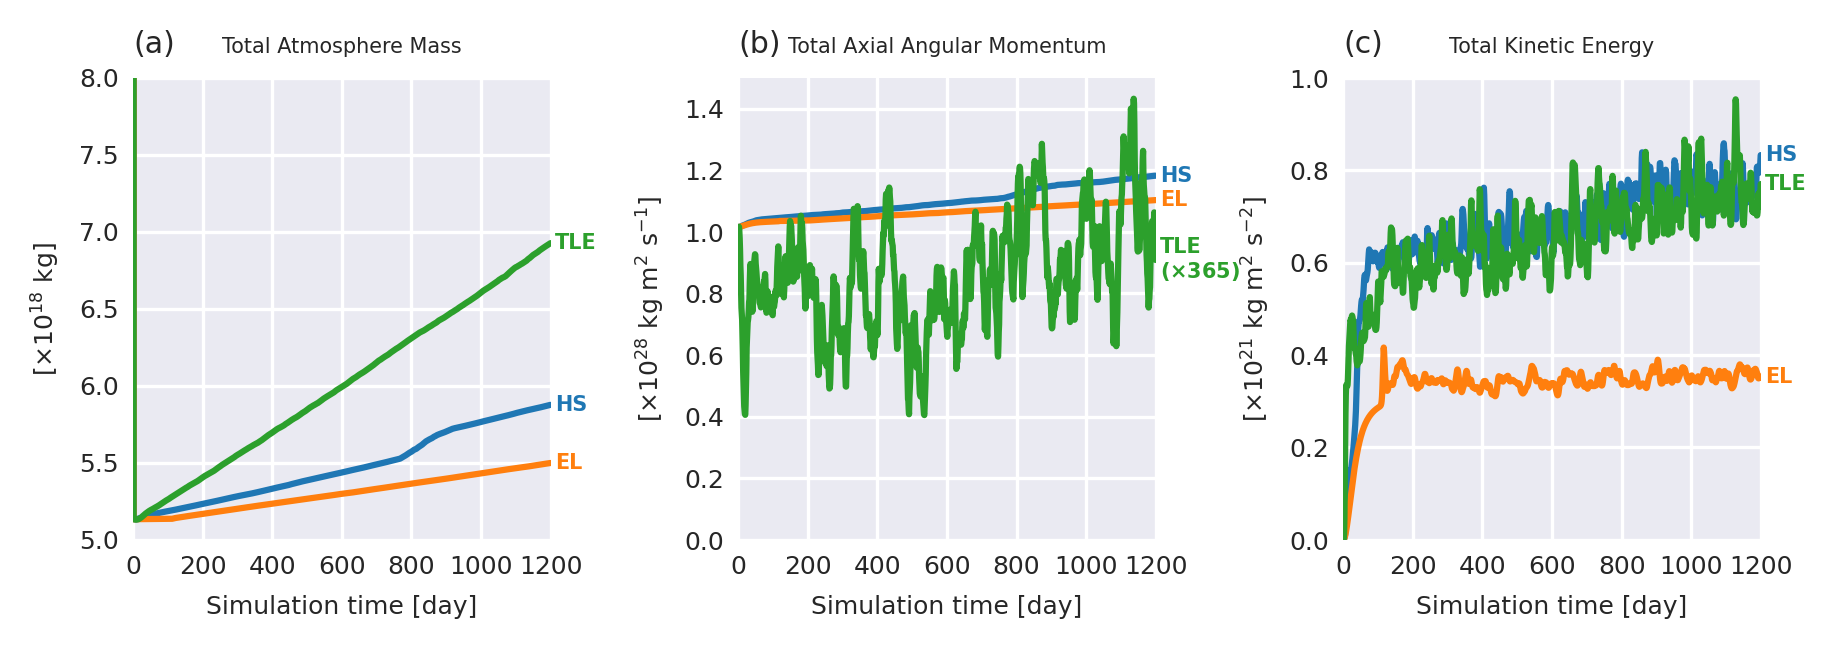

In [13]:
with plt.style.context("seaborn-v0_8-darkgrid"):
    fig = plt.figure(figsize=(7, 2))
    axd = fig.subplot_mosaic([DIAGS.keys()], gridspec_kw={"wspace": 0.45}, sharex=True)
    iletters = subplot_label_generator()
    for ax in axd.values():
        ax.set_title(f"({next(iletters)})", loc="left")

    model_key = "um"

    for diag_key, diag_prop in DIAGS.items():
        ax = axd[diag_key]
        ax.set_title(capitalise(diag_prop["name"]), size="small")
        ax.set_ylim(*diag_prop["lim"])
        ax.set_ylabel(rf"[$\times${diag_prop['tex_units']}]")
        ax.set_xlim(0, 1200)
        ax.set_xticks(np.arange(0, 1201, 200), dtype=int)
        if ax.get_subplotspec().is_last_row():
            ax.set_xlabel("Simulation time [day]")
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)
        for sim_label, sim_prop in SIM_CASES.items():
            cube = runs[model_key][sim_label].extract_cube(diag_prop["name"])
            cube.convert_units(tex2cf_units(diag_prop["tex_units"]))
            days = cube.coord("timestep").points * sim_prop["timestep"] / 86400
            if sim_label == "tle" and diag_key == "aam":
                factor = 365
                extra_note = "\n" + rf"($\times${factor})"
            else:
                factor = 1
                extra_note = ""
            x = days
            y = cube.data * factor
            ax.plot(x, y, **sim_prop["kw_plt"])
            ax.annotate(
                text=sim_prop["short_title"] + extra_note,
                xy=(x[-1], y[-1]),
                xytext=(1, 0),
                textcoords="offset points",
                va="center",
                color=sim_prop["kw_plt"]["color"],
                fontsize="small",
                weight="bold",
            )
    # add_custom_legend(
    #     fig,
    #     {v["title"]: v["kw_plt"] for v in SIM_CASES.values()},
    #     ncol=len(SIM_CASES),
    #     loc="upper center",
    #     bbox_to_anchor=(0.5, 1.1),
    # )
figsave(
    fig,
    paths.figures / f"exernal_forcing_um_{'_'.join(SIM_CASES.keys())}_conservation_diag",
)